**Emotion Detection in Tweets - LSTM Model from Scratch**

# SETUP for Colab

In [44]:
!pip install wordcloud

# Import **Libraries**

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from wordcloud import WordCloud
import os

# Load Dataset (Upload Files)

In [46]:
from google.colab import files
uploaded = files.upload()

# Load train / val / test
train_df = pd.read_csv('/content/train.txt', sep=';', names=['text', 'label'])
val_df = pd.read_csv('/content/val.txt', sep=';', names=['text', 'label'])
test_df = pd.read_csv('/content/test.txt', sep=';', names=['text', 'label'])

Saving test.txt to test (1).txt
Saving train.txt to train (1).txt
Saving val.txt to val (1).txt


# EDA

In [47]:
# Number of samples
print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Train samples: 16000
Validation samples: 2000
Test samples: 2000


In [48]:
# Unique classes
print("Classes:", train_df['label'].unique())

Classes: ['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']


In [49]:
# Unique classes
print("Classes:", test_df['label'].unique())

Classes: ['sadness' 'joy' 'fear' 'anger' 'love' 'surprise']


In [50]:
# Unique classes
print("Classes:", val_df['label'].unique())

Classes: ['sadness' 'love' 'anger' 'joy' 'fear' 'surprise']


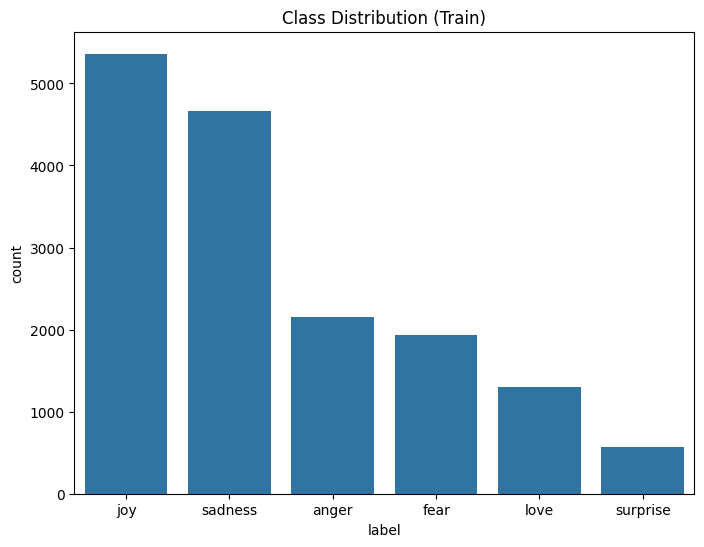

In [51]:
# Class balance
plt.figure(figsize=(8,6))
sns.countplot(data=train_df, x='label', order=train_df['label'].value_counts().index)
plt.title('Class Distribution (Train)')
plt.show()

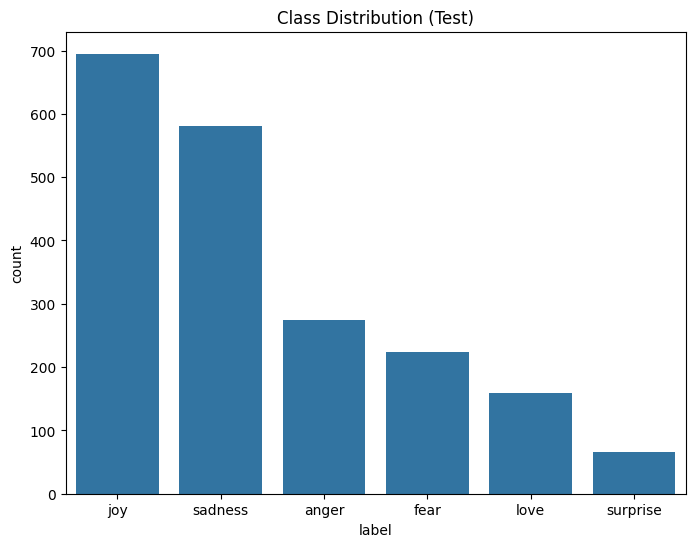

In [52]:
# Class balance
plt.figure(figsize=(8,6))
sns.countplot(data=test_df, x='label', order=test_df['label'].value_counts().index)
plt.title('Class Distribution (Test)')
plt.show()

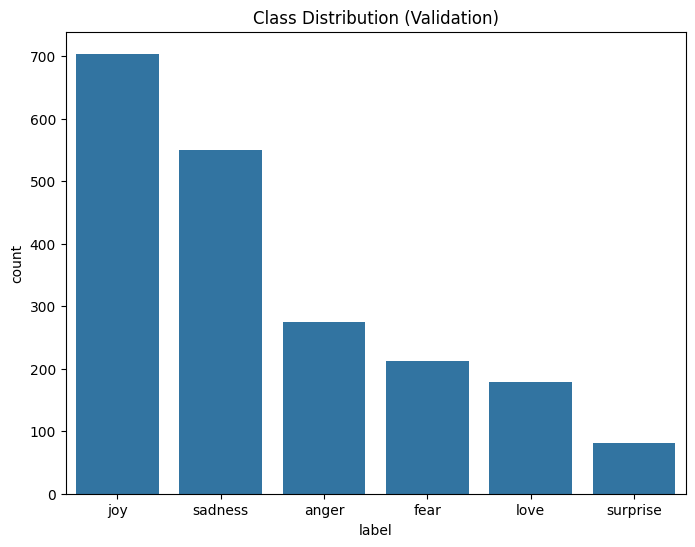

In [53]:
# Class balance
plt.figure(figsize=(8,6))
sns.countplot(data=val_df, x='label', order=val_df['label'].value_counts().index)
plt.title('Class Distribution (Validation)')
plt.show()

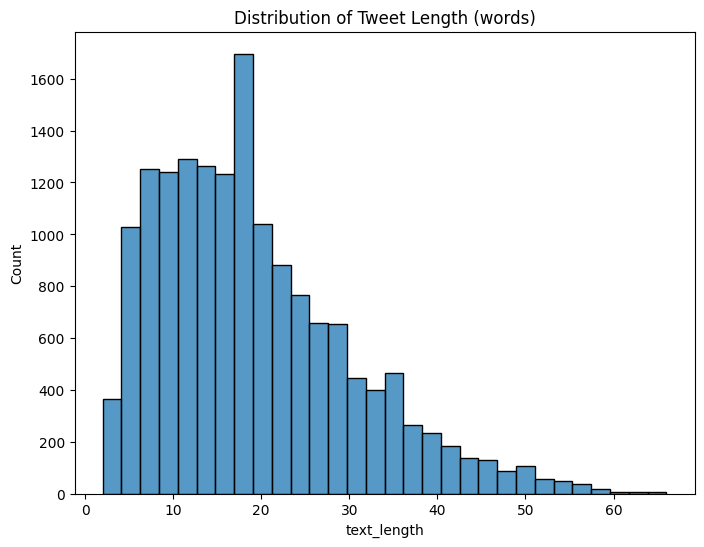

In [54]:
# Text length distribution
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,6))
sns.histplot(train_df['text_length'], bins=30)
plt.title('Distribution of Tweet Length (words)')
plt.show()

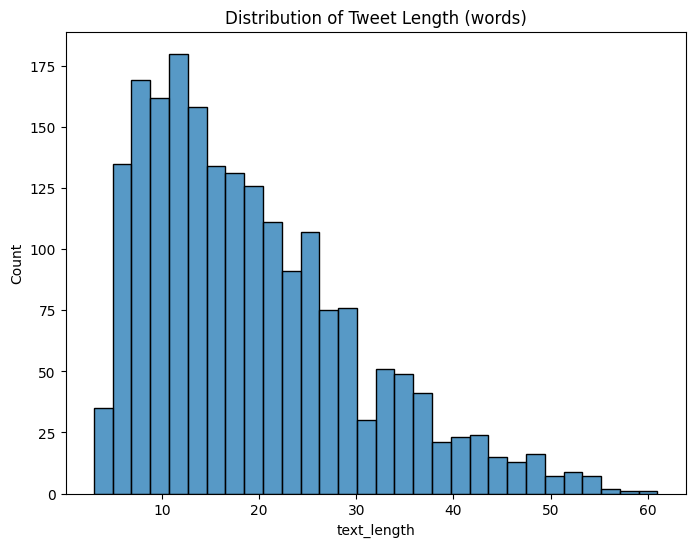

In [55]:
# Text length distribution
test_df['text_length'] = test_df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,6))
sns.histplot(test_df['text_length'], bins=30) # Changed to use test_df and the correct column name
plt.title('Distribution of Tweet Length (words)')
plt.show()

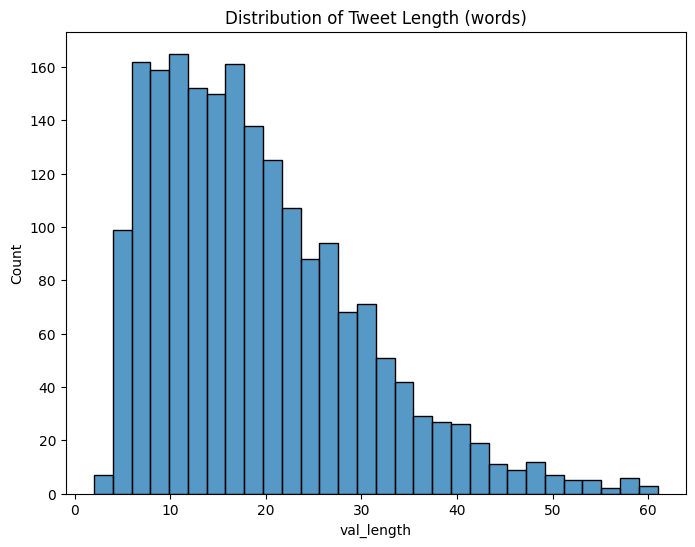

In [56]:
# Validation length distribution
# Calculate the text length for the 'text' column in the val_df DataFrame
val_df['val_length'] = val_df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,6))
sns.histplot(val_df['val_length'], bins=30)
plt.title('Distribution of Tweet Length (words)')
plt.show()

In [57]:
# Example per class
for label in train_df['label'].unique():
    print(f"\nLabel: {label}")
    print(train_df[train_df['label'] == label]['text'].sample(1).values[0])


Label: sadness
i remember feeling so lonely as a child in my room even though i had a lot of toys to keep me occupied

Label: anger
ive come to realize i need to stop runnin away from my fears gotta stop bein so confined and wanting to hide feeling the need to die and instead stic through this vicious hell like ride

Label: love
i feel this way as this version of myself gentle gazing i realise something over and over again

Label: surprise
i say walking away and shaking my head feeling a little dazed to get the drinks

Label: fear
i can tell you the things i don t feel that maybe i should be feeling but i can t really put my finger on the cause of my being shaken

Label: joy
i hope that this does not deeply affend anyone but if it does than maybe you know who i feel now after years of being a faithful catholic to be told you are going to hell anyways because of what you do in the privacy of your own home


In [58]:
# Example per class
for label in test_df['label'].unique():
    print(f"\nLabel: {label}")
    # Access the 'text' column instead of the non-existent 'test' column
    print(test_df[test_df['label'] == label]['text'].sample(1).values[0])


Label: sadness
i mean i feel like a broke record sometimes

Label: joy
i thought yoga was supposed to make me feel tranquil peaceful and sculpt my legs into those of a greek goddess

Label: fear
i can cope with his presence without feeling distressed if i can force myself into a quiet and resigned friendship

Label: anger
i don t want to i feel irritated

Label: love
i feel affirmed gracious sensuous and will have less self doubt when a href http generations

Label: surprise
i feel more amazed and more thankful for having e in our lives


In [59]:
# Example per class
for label in val_df['label'].unique():
    print(f"\nLabel: {label}")
    # Access the 'text' column instead of the non-existent 'test' column
    print(val_df[val_df['label'] == label]['text'].sample(1).values[0])


Label: sadness
i forgive stanley hes not so quick to forgive as well and accuses me of making a foolish mistake and making him feel unwelcome in our apt

Label: love
im feeling a little tender and mashed today and im doing my best

Label: anger
id love to go shopping for sure because i am annoyed feeling bitchy as of right now towards everyone especially you you you

Label: joy
i have spent days on the problem i am now feeling eager to finish the job the plan is go into work try my solution and then get on the phone to tell the customer what to do div style clearboth padding bottom

Label: fear
i love to be beside the ocean when i feel distressed

Label: surprise
i really did not feel so impressed with houston when i came here last time


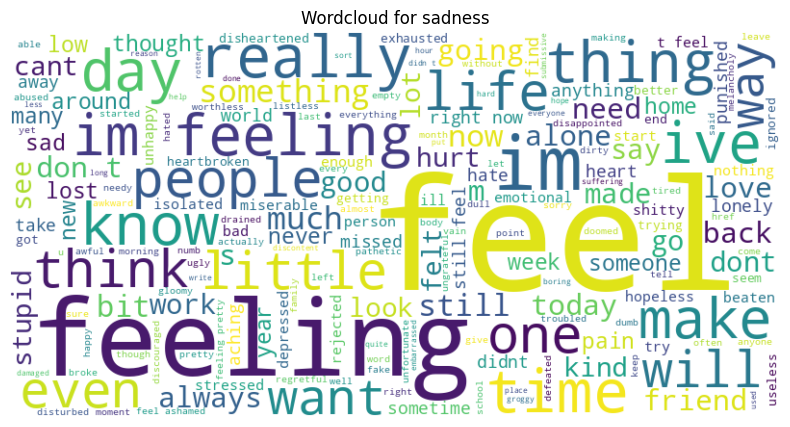

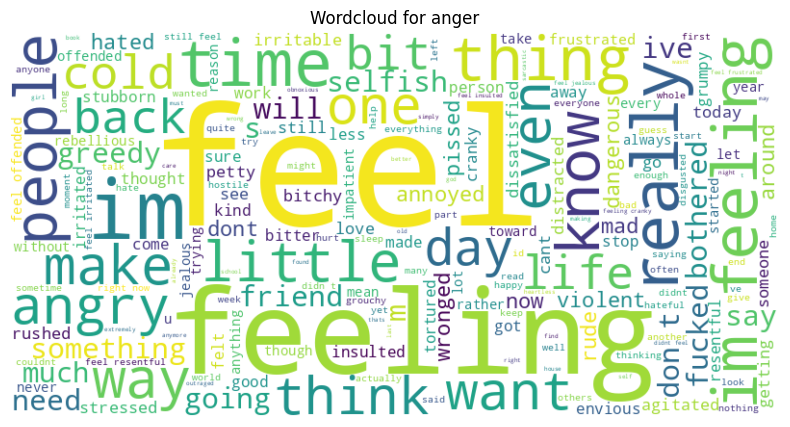

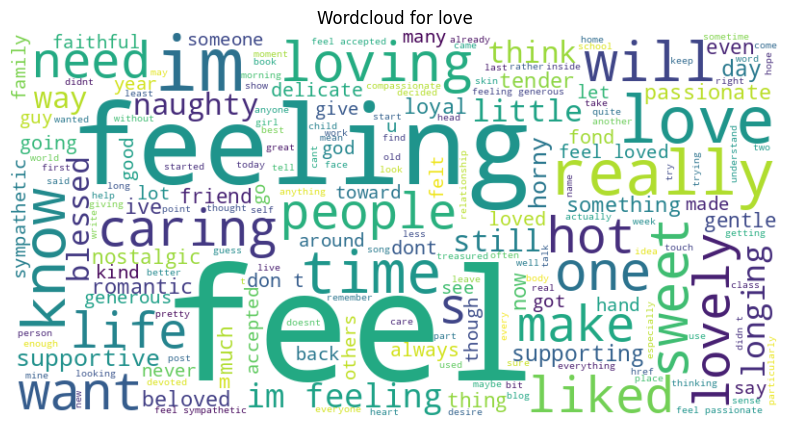

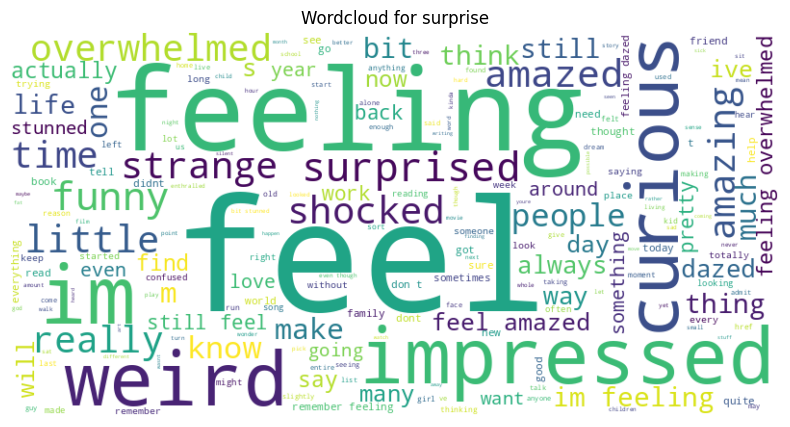

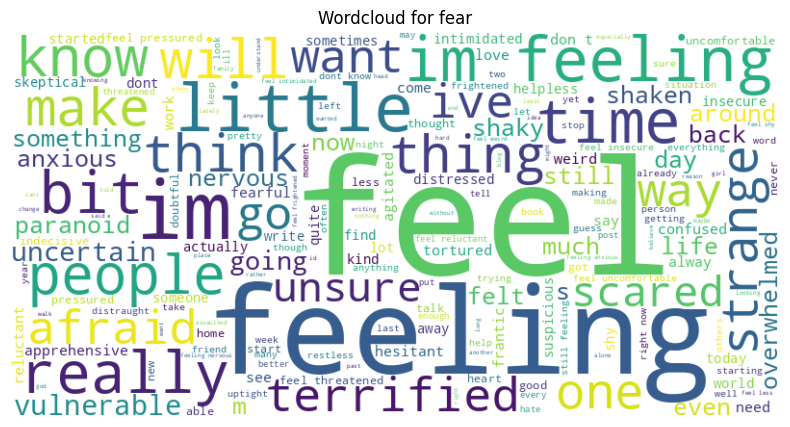

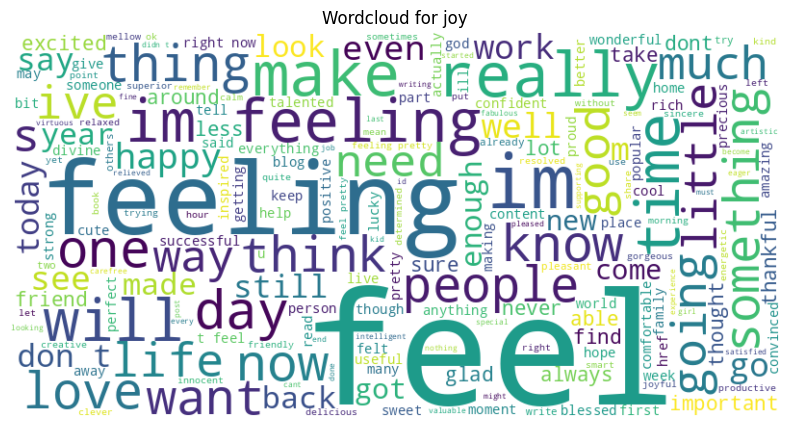

In [60]:
# Wordclouds
for label in train_df['label'].unique():
    text = " ".join(train_df[train_df['label'] == label]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Wordcloud for {label}")
    plt.show()

## Checking null and removing Duplicates in train

In [61]:
print(train_df.isnull().sum())
print(train_df.duplicated().sum())

# removing Duplicates
index = train_df[train_df.duplicated()==True].index
train_df.drop(index , axis =0 ,inplace=True)
train_df.reset_index(inplace=True, drop=True)

print(train_df.duplicated().sum())

text           0
label          0
text_length    0
dtype: int64
1
0


## Checking null and removing Duplicates in test

In [62]:
print(test_df.isnull().sum())
print(test_df.duplicated().sum())

text           0
label          0
text_length    0
dtype: int64
0


## Checking null and removing Duplicates in val

In [63]:
print(val_df.isnull().sum())
print(val_df.duplicated().sum())

text          0
label         0
val_length    0
dtype: int64
0


In [64]:
#text lengths
train_df['text_len'] = train_df['text'].apply(lambda x: len(x.split()))
val_df['text_len'] = val_df['text'].apply(lambda x: len(x.split()))
test_df['text_len'] = test_df['text'].apply(lambda x: len(x.split()))

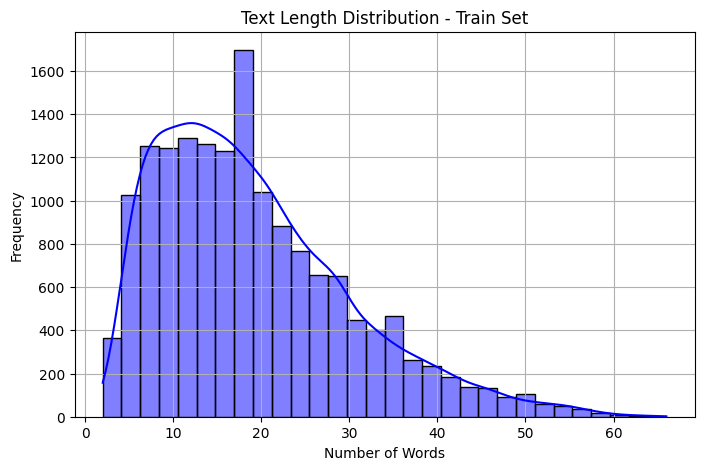

In [65]:
#Train Set
plt.figure(figsize=(8, 5))
sns.histplot(train_df['text_len'], bins=30, kde=True, color='blue')
plt.title("Text Length Distribution - Train Set")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

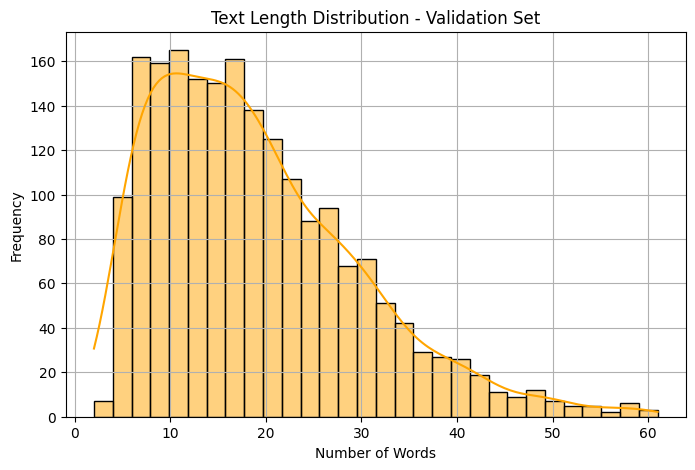

In [66]:
#Validation Set
plt.figure(figsize=(8, 5))
sns.histplot(val_df['text_len'], bins=30, kde=True, color='orange')
plt.title("Text Length Distribution - Validation Set")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

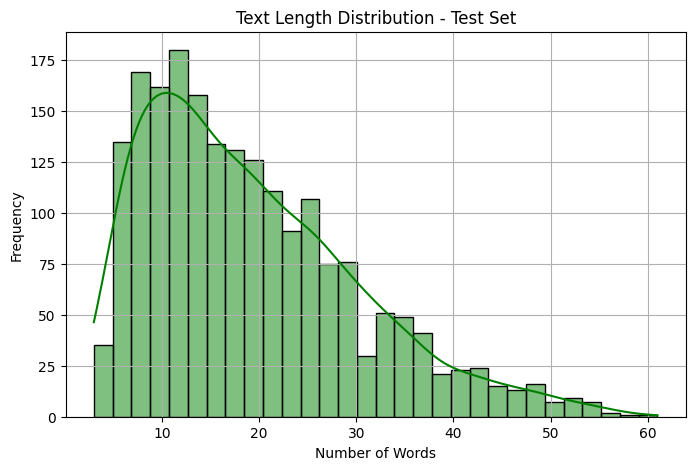

In [67]:
# Test Set
plt.figure(figsize=(8, 5))
sns.histplot(test_df['text_len'], bins=30, kde=True, color='green')
plt.title("Text Length Distribution - Test Set")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

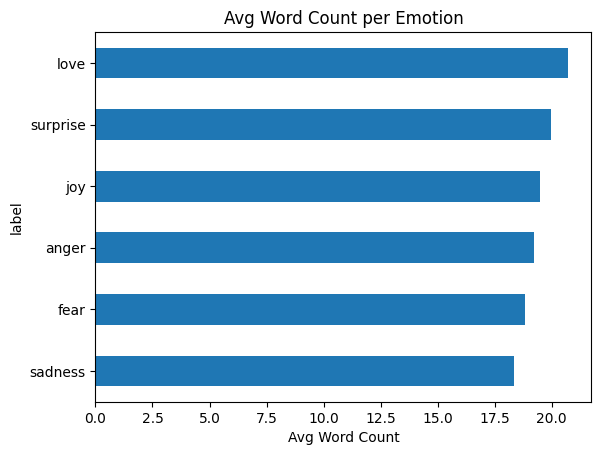

In [68]:
# Words
train_df.groupby('label')['text_len'].mean().sort_values().plot(kind='barh', title="Avg Word Count per Emotion")
plt.xlabel("Avg Word Count")
plt.show()

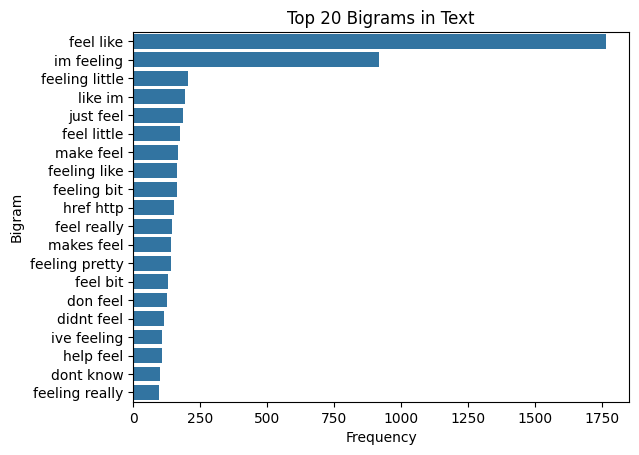

In [69]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(train_df['text'])
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# Plot top 20 bigrams
top_20_bigrams = words_freq[:20]
bigrams_df = pd.DataFrame(top_20_bigrams, columns=['Bigram', 'Frequency'])
sns.barplot(y='Bigram', x='Frequency', data=bigrams_df)
plt.title("Top 20 Bigrams in Text")
plt.show()

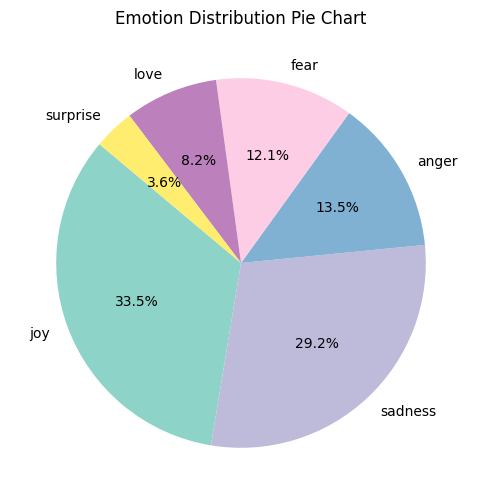

In [70]:
plt.figure(figsize=(6, 6))
train_df['label'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, cmap='Set3')
plt.title("Emotion Distribution Pie Chart")
plt.ylabel('')
plt.show()

### identification of outliers

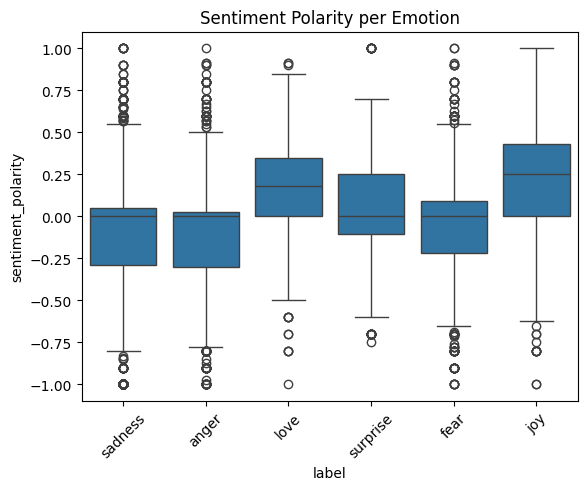

In [71]:
from textblob import TextBlob

train_df['sentiment_polarity'] = train_df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

sns.boxplot(data=train_df, x='label', y='sentiment_polarity')
plt.xticks(rotation=45)
plt.title("Sentiment Polarity per Emotion")
plt.show()

# Preprocessing

### Comparision of rows in Dataset

####Define the dataframe_difference function:

In [72]:
def dataframe_difference(df1, df2, which=None):
    """
    Find rows which are different between two DataFrames.
    """
    comparison_df = df1.merge(
        df2,
        indicator=True,
        how='outer'
    )
    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]
    return diff_df


#### function to compare train/val/test sets for overlaps:

In [73]:
print("Checking overlap between train and test:")
print(dataframe_difference(train_df, test_df, which='both'))

print("Checking overlap between train and validation:")
print(dataframe_difference(train_df, val_df, which='both'))

print("Checking overlap between validation and test:")
print(dataframe_difference(val_df, test_df, which='both'))

Checking overlap between train and test:
Empty DataFrame
Columns: [text, label, text_length, text_len, sentiment_polarity, _merge]
Index: []
Checking overlap between train and validation:
Empty DataFrame
Columns: [text, label, text_length, text_len, sentiment_polarity, val_length, _merge]
Index: []
Checking overlap between validation and test:
Empty DataFrame
Columns: [text, label, val_length, text_len, text_length, _merge]
Index: []


#### Remove overlapping rows from validation and test sets

In [74]:
# Remove overlapping rows in validation
overlap_train_val = dataframe_difference(train_df, val_df, which='both')
val_df = val_df[~val_df['text'].isin(overlap_train_val['text'])]


In [75]:
# Remove overlapping rows in test
overlap_train_test = dataframe_difference(train_df, test_df, which='both')
test_df = test_df[~test_df['text'].isin(overlap_train_test['text'])]


### Cleaning the Dataset

#### Import NLTK and download required corpora:

In [76]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [77]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Define text cleaning functions:

In [78]:
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()
    text = text.split()
    text=[lemmatizer.lemmatize(y) for y in text]
    return " ".join(text)

def remove_stop_words(text):
    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):
    text = text.split()
    text=[y.lower() for y in text]
    return " ".join(text)

def Removing_punctuations(text):
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"")
    text = re.sub('\s+', ' ', text)
    text = " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)


#### Apply normalization pipeline to train, val, test sets:

In [79]:
def normalize_text(df, col_name):
    df[col_name] = df[col_name].apply(lower_case)
    df[col_name] = df[col_name].apply(remove_stop_words)
    df[col_name] = df[col_name].apply(Removing_numbers)
    df[col_name] = df[col_name].apply(Removing_punctuations)
    df[col_name] = df[col_name].apply(Removing_urls)
    df[col_name] = df[col_name].apply(lemmatization)
    return df

# Apply normalization
train_df = normalize_text(train_df, 'text')
val_df = normalize_text(val_df, 'text')
test_df = normalize_text(test_df, 'text')

In [80]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

train_df['clean_text'] = train_df['text'].apply(clean_text)
val_df['clean_text'] = val_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

#### Alternative clean_text function (simpler cleaning):

In [81]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

train_df['clean_text'] = train_df['text'].apply(clean_text)
val_df['clean_text'] = val_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)


#### Initialize tokenizer:

In [82]:
MAX_VOCAB = 10000
MAX_LEN = 50

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['clean_text'])

#### Convert texts to padded sequences:

In [83]:
X_train = pad_sequences(tokenizer.texts_to_sequences(train_df['clean_text']), maxlen=MAX_LEN)
X_val = pad_sequences(tokenizer.texts_to_sequences(val_df['clean_text']), maxlen=MAX_LEN)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df['clean_text']), maxlen=MAX_LEN)

#### Encode labels to categorical:

In [84]:
label_encoder = LabelEncoder()
label_encoder.fit(train_df['label'])

y_train = to_categorical(label_encoder.transform(train_df['label']))
y_val = to_categorical(label_encoder.transform(val_df['label']))
y_test = to_categorical(label_encoder.transform(test_df['label']))

# Label Encoding

In [85]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform labels for all datasets
train_labels_encoded = label_encoder.fit_transform(train_df['label'])
val_labels_encoded = label_encoder.transform(val_df['label'])
test_labels_encoded = label_encoder.transform(test_df['label'])

# Convert integer labels to one-hot encoded vectors
num_classes = len(label_encoder.classes_)
train_labels_one_hot = to_categorical(train_labels_encoded, num_classes=num_classes)
val_labels_one_hot = to_categorical(val_labels_encoded, num_classes=num_classes)
test_labels_one_hot = to_categorical(test_labels_encoded, num_classes=num_classes)

print("\nOriginal labels:", train_df['label'].head())
print("Encoded labels:", train_labels_encoded[:5])
print("One-hot encoded labels:", train_labels_one_hot[:5])
print("Number of classes:", num_classes)


Original labels: 0    sadness
1    sadness
2      anger
3       love
4      anger
Name: label, dtype: object
Encoded labels: [4 4 0 3 0]
One-hot encoded labels: [[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]
Number of classes: 6


# Build Model

1. Embedding Layer
- Converts each integer word index into a dense vector of fixed size (EMBEDDING_DIM = 100).
- These vectors are learned during training (random initialized initially).
- Purpose: capture semantic meaning of words in a continuous vector space.

2. LSTM Layer
- Long Short-Term Memory (LSTM) is a type of Recurrent Neural Network (RNN) specialized for sequence data.
- Processes the sequence of word embeddings step-by-step, keeping track of information over time.
- Can capture context and dependencies between words, which is critical in understanding emotions in text.
- Here, we use 128 units, and return_sequences=False means it outputs the final state vector summarizing the whole tweet.

3. Training
- Model learns from the training data for 10 epochs.
- Batch size of 32: model weights updated every 32 samples.
- Validation data used to monitor overfitting and performance on unseen data.

In [87]:
from tensorflow.keras.layers import Input

# Define embedding_dim
EMBEDDING_DIM = 100

model = Sequential([
    Input(shape=(MAX_LEN,)),
    Embedding(MAX_VOCAB, EMBEDDING_DIM),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Now Keras already “knows” the shape, so summary() will be built.
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50, 128)        │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,171,206 (4.47 MB)

 Trainable params: 1,171,206 (4.47 MB)

 Non-trainable params: 0 (0.00 B)

# Train Model

## Interpretation of Training Output

- The accuracy improves over epochs both on training and validation sets.
- The loss decreases steadily, showing the model learns to reduce classification errors.
- Watch for signs of overfitting (training accuracy much higher than validation accuracy).
- Here, validation accuracy around 92-93% indicates good generalization.

In [88]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Model compiled successfully!")

# Use the correct variable names X_train and X_val for padded sequences
history = model.fit(X_train, train_labels_one_hot,
                    epochs=20, # You might need to tune this
                    batch_size=32, # You might need to tune this
                    validation_data=(X_val, val_labels_one_hot),
                    verbose=1)
print("\nModel training complete!")

Model compiled successfully!
Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 143ms/step - accuracy: 0.3534 - loss: 1.5400 - val_accuracy: 0.7565 - val_loss: 0.6763
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 144ms/step - accuracy: 0.8104 - loss: 0.5182 - val_accuracy: 0.9065 - val_loss: 0.2661
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 78s 135ms/step - accuracy: 0.9327 - loss: 0.1990 - val_accuracy: 0.9220 - val_loss: 0.2362
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 81s 133ms/step - accuracy: 0.9537 - loss: 0.1363 - val_accuracy: 0.9235 - val_loss: 0.2326
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 133ms/step - accuracy: 0.9672 - loss: 0.1001 - val_accuracy: 0.9265 - val_loss: 0.2525
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 67s 133ms/step - accuracy: 0.9702 - loss: 0.0874 - val_accuracy: 0.9290 - val_loss: 0.2772
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 133ms/step - accuracy: 0.9811 - loss: 0.0602 - val_accuracy: 0.9295 - val_loss: 0.3048
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 81s 132ms/step

# Evaluate the Model (including Evaluate on Test Data, Generate Predictions, and Classification Report)

In [89]:
loss, accuracy = model.evaluate(X_test, test_labels_one_hot, verbose=0)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Test Loss: 0.5364
Test Accuracy: 0.9230


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step

Classification Report:
              precision    recall  f1-score   support

       anger       0.92      0.90      0.91       275
        fear       0.89      0.89      0.89       224
         joy       0.95      0.94      0.95       695
        love       0.81      0.82      0.81       159
     sadness       0.96      0.97      0.96       581
    surprise       0.74      0.79      0.76        66

    accuracy                           0.92      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.92      0.92      0.92      2000



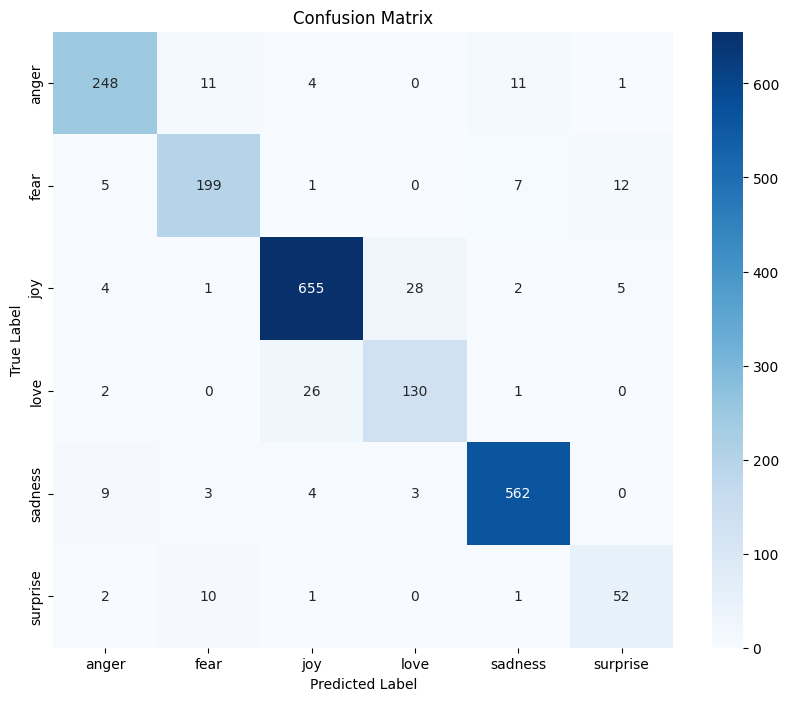

In [90]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
predictions_one_hot = model.predict(X_test) # Changed from test_padded to X_test
# Convert one-hot predictions back to class labels
predictions_encoded = np.argmax(predictions_one_hot, axis=1)

# Get true labels (from original encoded test_labels_encoded before one-hot)
# test_labels_encoded should be available from your preprocessing step

# Convert encoded labels back to original string labels for clarity in report
true_labels_str = label_encoder.inverse_transform(test_labels_encoded)
predicted_labels_str = label_encoder.inverse_transform(predictions_encoded)

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels_str, predicted_labels_str, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(true_labels_str, predicted_labels_str, labels=label_encoder.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

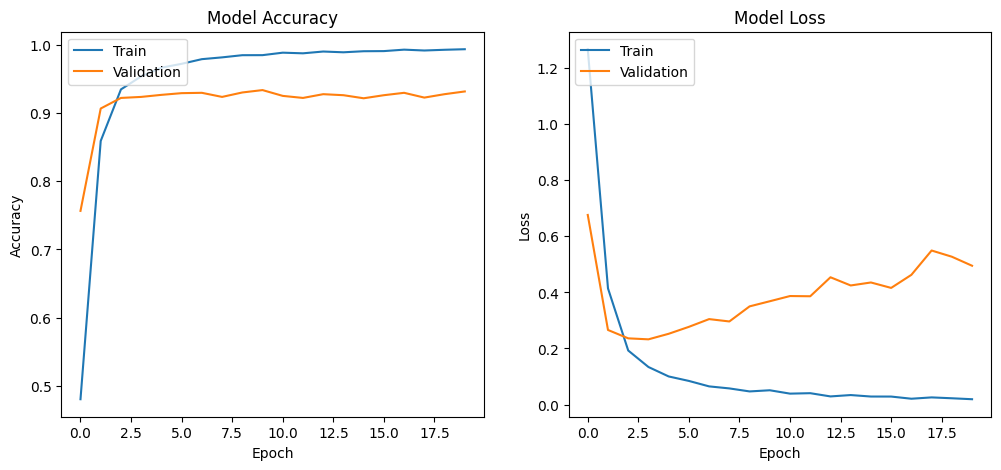

In [91]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluation

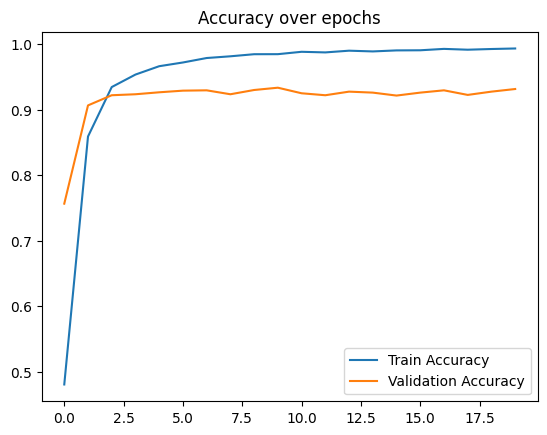

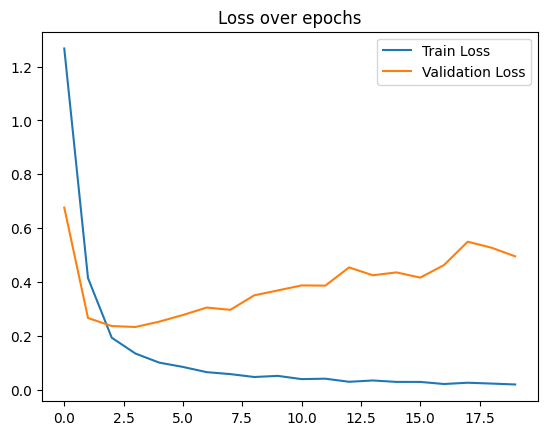

In [92]:
# Accuracy and loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step
Classification Report:
              precision    recall  f1-score   support

       anger       0.92      0.90      0.91       275
        fear       0.89      0.89      0.89       224
         joy       0.95      0.94      0.95       695
        love       0.81      0.82      0.81       159
     sadness       0.96      0.97      0.96       581
    surprise       0.74      0.79      0.76        66

    accuracy                           0.92      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.92      0.92      0.92      2000



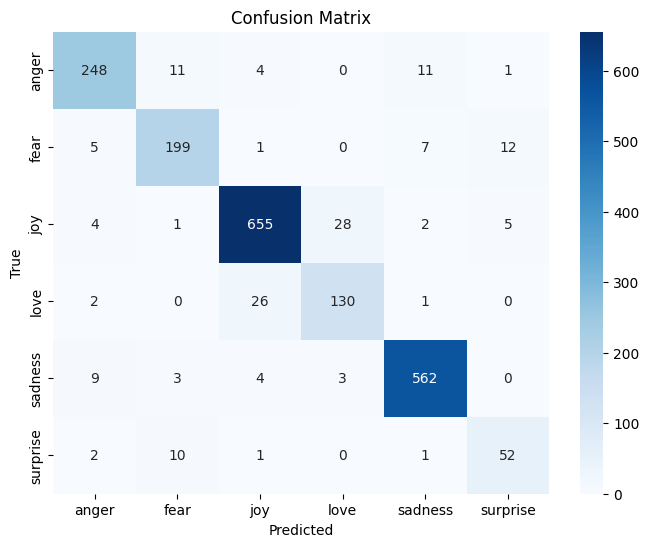

In [93]:
# Test set evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save model

In [94]:
model.save('emotion_lstm_model.h5')
print("Model saved as emotion_lstm_model.h5")

Model saved as emotion_lstm_model.h5


# t-SNE Visualization

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


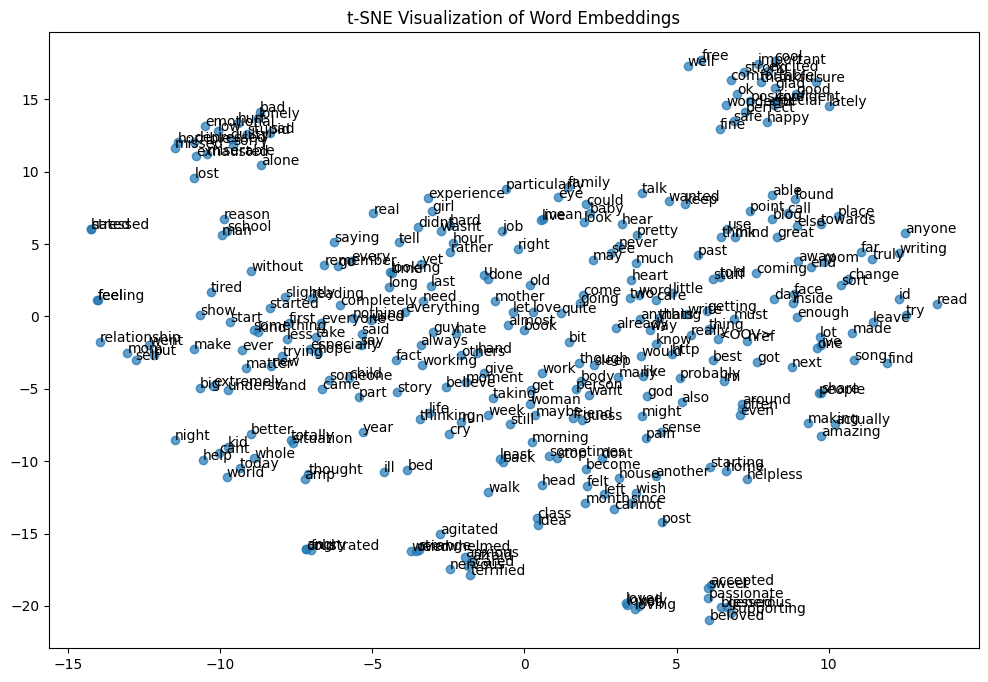

In [95]:
embedding_layer = model.layers[0]
embedding_weights = embedding_layer.get_weights()[0]

# Pick first N words
N = 300
words = list(tokenizer.word_index.keys())[:N]
word_embeddings = embedding_weights[1:N+1]

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
embeddings_2d = tsne.fit_transform(word_embeddings)

plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
for i, word in enumerate(words):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.title('t-SNE Visualization of Word Embeddings')
plt.show()

# Predictions

In [96]:
predict_test = np.argmax(model.predict(X_test),axis=-1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step


In [97]:
# as per the dataset description, index value is mapped with the corresponding emotion in the list

emotions = ['sadness','joy','love','anger','fear','surprise']

In [98]:
def predict(n):
    # Check if the index n is within the bounds of the test_df DataFrame
    if n < len(test_df):
        # Use test_df instead of the undefined 'test' variable
        print(test_df['text'].iloc[n])
        print("Actual label: ", emotions[label_encoder.transform([test_df['label'].iloc[n]])[0]])
        print("Predict label: ",emotions[predict_test[n]])
    else:
        print(f"Index {n} is out of bounds for the test dataset.")

In [99]:
n = 15
p = list(np.random.randint(low = 0, high = 2000, size = n))
for i in p:
    predict(i)
    print("-------------------------------------------------------------------------------------------")

felt bad bad grade feeling like hide didnt know say except declare frustration hated school
Actual label:  fear
Predict label:  sadness
-------------------------------------------------------------------------------------------
sit snowy ohio countryside christmas eve feeling like postcard thrilled announce found
Actual label:  love
Predict label:  love
-------------------------------------------------------------------------------------------
left feeling empty
Actual label:  fear
Predict label:  fear
-------------------------------------------------------------------------------------------
figured parent wont make feel accepted stopped trying turned romantic relationship men
Actual label:  anger
Predict label:  anger
-------------------------------------------------------------------------------------------
feel drained end novel try hardest get something change impact life
Actual label:  fear
Predict label:  fear
---------------------------------------------------------------------

In [100]:
def predict_text(test):
    txt = tokenizer.texts_to_sequences([test])
    txt = pad_sequences(txt,maxlen=128)
    pred = np.argmax(model.predict(txt))

    return emotions[pred]

In [101]:
txt = '''Giving away something that was of great benefit or of requirement to the receiver definitely
brings in a feel of happiness and fulfillment. No matter whatever situation you may be in, when you pass
out things that are of great help and happiness to others, you too feel the same.'''

print("Predicted emotion: ", predict_text(txt))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
Predicted emotion:  fear


In [102]:
txt = '''He well remembered the last interview he had had with the old prince at the time of the enrollment,
when in reply to an invitation to dinner he had had to listen to an angry
reprimand for not having provided his full quota of men.'''

print("Predicted emotion: ", predict_text(txt))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted emotion:  sadness
